In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
%pwd

'd:\\Chest-Cancer-Classification'

In [4]:
from dataclasses  import dataclass
from pathlib import Path

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    validation_data : Path
    test_data : Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list
    results_folder: Path

In [6]:
from chestCancerClassification.constants import *
from chestCancerClassification.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    
    def __init__(self, config_file_path = CONFIG_FILE_PATH, param_file_path = PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_file_path)
        self.param = read_yaml(param_file_path)
        
        create_directories([self.config.artifacts_root])
    
    def get_training_config_vgg16(self) -> TrainingConfig:
        config = self.config.training
        params = self.param.VGG16
        prepare_base_model = self.config.prepare_base_model
        
        training_data = os.path.join(self.config.data_ingestion.unzip_data, "train")
        validation_data = os.path.join(self.config.data_ingestion.unzip_data, "valid")
        test_data = os.path.join(self.config.data_ingestion.unzip_data, "test")
      
        
        create_directories([
            Path(config.root_dir),
            Path(config.results_dir)
        ])
        
        print("training_data", training_data)
        
        training_config = TrainingConfig(
            root_dir=Path(config.root_dir),
            trained_model_path=Path(config.trained_model_path_vgg16),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_vgg16),
            training_data=Path(training_data),
            validation_data=Path(validation_data),
            test_data=Path(test_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE,
            results_folder=Path(config.results_dir)
        )

        return training_config
    
    def get_training_config_vgg19(self) -> TrainingConfig:
        config = self.config.training
        params = self.param.VGG19
        prepare_base_model = self.config.prepare_base_model
        
        training_data = os.path.join(self.config.data_ingestion.unzip_data, "train")
        validation_data = os.path.join(self.config.data_ingestion.unzip_data, "valid")
        test_data = os.path.join(self.config.data_ingestion.unzip_data, "test")
      
        
        create_directories([
            Path(config.root_dir),
            Path(config.results_dir)
        ])
        
        print("training_data", training_data)
        
        training_config = TrainingConfig(
            root_dir=Path(config.root_dir),
            trained_model_path=Path(config.trained_model_path_vgg19),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_vgg19),
            training_data=Path(training_data),
            validation_data=Path(validation_data),
            test_data=Path(test_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE,
            results_folder=Path(config.results_dir)
        )

        return training_config


        
        
        

In [8]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import numpy as np
import pandas as pd
from chestCancerClassification import logger
from sklearn.metrics import precision_recall_fscore_support

[2023-12-15 19:10:42,444] : WARNING : module_wrapper : From d:\Chest-Cancer-Classification\env\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.
]


In [9]:
from sklearn.metrics import precision_recall_fscore_support


class Training:
    def __init__(self, config: TrainingConfig, model_name: str):
        self.config = config
        self.model = None
        self.train_generator = None
        self.valid_generator = None
        self.test_generator = None
        self.model_name = model_name

    def get_base_model(self):
        self.model = tf.keras.models.load_model(self.config.updated_base_model_path)

    def setup_data_generators(self):
        datagenerator_kwargs = dict(rescale=1./255)
        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        # Train generator with augmentation
        train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=40, horizontal_flip=True, width_shift_range=0.2, 
            height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
            **datagenerator_kwargs
        ) if self.config.params_is_augmentation else tf.keras.preprocessing.image.ImageDataGenerator(**datagenerator_kwargs)

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data, shuffle=True, **dataflow_kwargs
        )

        # Validation generator
        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(**datagenerator_kwargs)
        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.validation_data, shuffle=False, **dataflow_kwargs
        )

        # Test generator
        test_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(**datagenerator_kwargs)
        self.test_generator = test_datagenerator.flow_from_directory(
            directory=self.config.test_data, shuffle=False, **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)

    def plot_training_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Training accuracy')
        plt.plot(epochs, val_acc, label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.savefig(os.path.join(self.config.results_folder, f'{self.model_name}_training_history.png'))
        plt.show()

    def evaluate_and_report(self):
        test_loss, test_accuracy = self.model.evaluate(self.test_generator)
        print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

        predictions = np.argmax(self.model.predict(self.test_generator), axis=1)
        true_classes = self.test_generator.classes
        class_labels = list(self.test_generator.class_indices.keys())

        cm = confusion_matrix(true_classes, predictions)
        self.plot_confusion_matrix(cm, class_labels)

        precision, recall, f1_score, _ = precision_recall_fscore_support(true_classes, predictions, average='weighted')
        self.append_to_csv(test_accuracy, precision, recall, f1_score)

    def plot_confusion_matrix(self, cm, classes):
        plt.figure(figsize=(10, 10))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(os.path.join(self.config.results_folder, f'confusion_matrix_{self.model_name}.png'))
        plt.show()

    def append_to_csv(self, accuracy, precision, recall, f1_score):
        results_file = os.path.join(self.config.results_folder, 'results.csv')
        new_row = {'Model': self.model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}

        if not os.path.isfile(results_file):
            pd.DataFrame([new_row]).to_csv(results_file, index=False)
        else:
            pd.DataFrame([new_row]).to_csv(results_file, mode='a', header=False, index=False)

    def train(self):
        # create_directories([self.config.results_folder])

        self.get_base_model()
        self.setup_data_generators()

        steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator, epochs=self.config.params_epochs, 
            steps_per_epoch=steps_per_epoch, validation_data=self.valid_generator, 
            validation_steps=validation_steps
        )

        self.save_model(path=self.config.trained_model_path, model=self.model)
        self.plot_training_history(history)
        self.evaluate_and_report()

[2023-12-15 19:10:50,069] : INFO : common : yaml file: config\config.yaml loaded successfully]
[2023-12-15 19:10:50,074] : INFO : common : yaml file: params.yaml loaded successfully]
[2023-12-15 19:10:50,075] : INFO : common : created directory at: artifacts]
[2023-12-15 19:10:50,075] : INFO : 2343774759 : Training start for VGG16 model]
[2023-12-15 19:10:50,076] : INFO : common : created directory at: artifacts\training]
[2023-12-15 19:10:50,077] : INFO : common : created directory at: results]
training_data artifacts/data_ingestion\train
TrainingConfig(root_dir=WindowsPath('artifacts/training'), trained_model_path=WindowsPath('artifacts/training/vgg16.h5'), updated_base_model_path=WindowsPath('artifacts/base_models/updated_vgg16.h5'), training_data=WindowsPath('artifacts/data_ingestion/train'), validation_data=WindowsPath('artifacts/data_ingestion/valid'), test_data=WindowsPath('artifacts/data_ingestion/test'), params_epochs=10, params_batch_size=32, params_is_augmentation=True, para

d:\Chest-Cancer-Classification\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


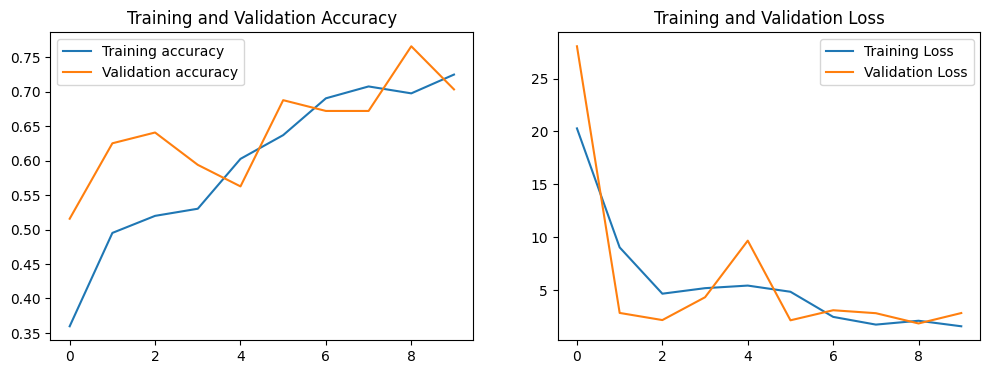

10/10 [==============================] - 18s 2s/step - loss: 3.1102 - accuracy: 0.6381
Test Accuracy: 0.6380952596664429, Test Loss: 3.1101880073547363
10/10 [==============================] - 17s 2s/step


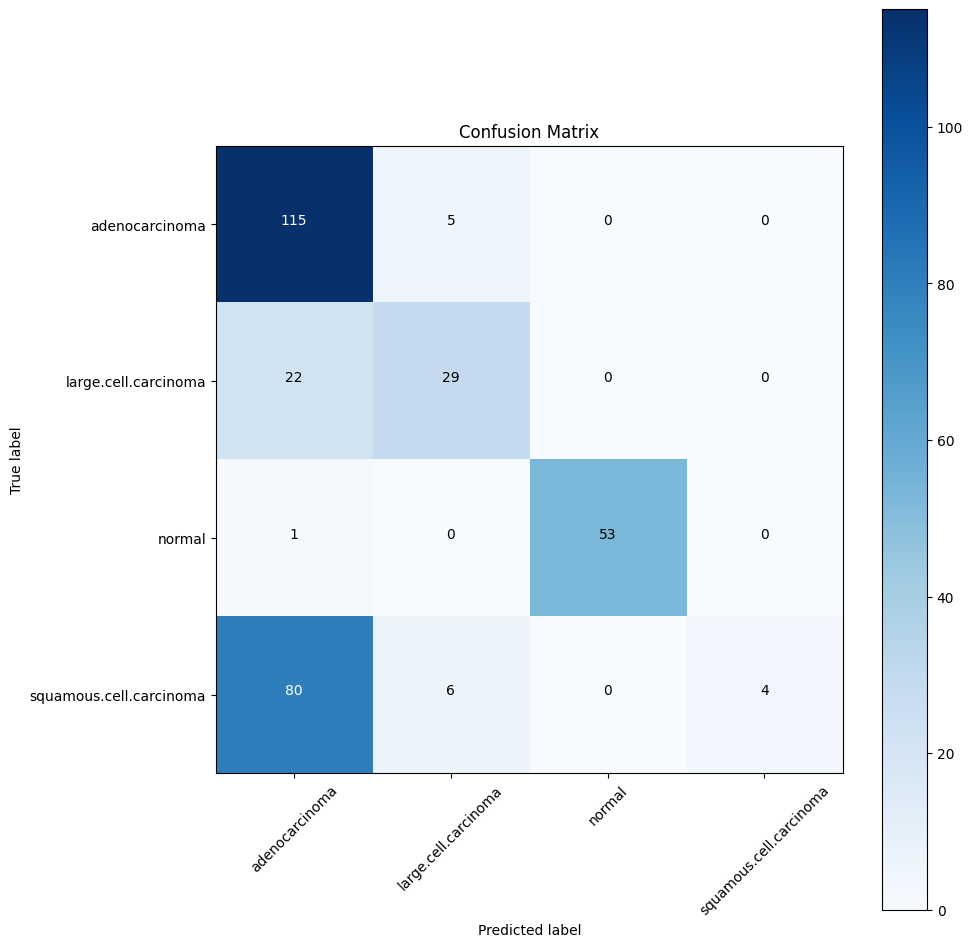

[2023-12-15 19:17:22,631] : INFO : 2343774759 : Training ended successfully for VGG16 model]


In [11]:
try:
    config = ConfigurationManager()
    
    logger.info("Training start for VGG16 model")
    
    training_config = config.get_training_config_vgg16()
    
    # print(training_config)
    training = Training(config=training_config, model_name = "VGG16")
    training.train()
    
    logger.info("Training ended successfully for VGG16 model")
    
    
    
    logger.info("Training start for VGG19 model")
    
    training_config = config.get_training_config_vgg19()
    
    print("VGG19 Training Config", training_config)
    logger.info("VGG19 Training Config", training_config)
    training = Training(config=training_config, model_name = "VGG19")
    training.train()
    
    logger.info("Training ended successfully for VGG19 model")
except Exception as e:
    raise e